In [1]:
from torchvision import datasets, transforms

# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor()
])

# 加载CIFAR10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        # input_dim: 输入维度（28*28=784）
        # hidden_dim: 隐藏层维度
        # latent_dim: 潜在变量维度
        super(VAE, self).__init__()
        
        # 编码器
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            # 输入层到隐藏层，全连接
            nn.Linear(input_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU(),
            # 全连接层
            nn.Linear(hidden_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU()
        )

        # 均值和对数方差的全连接层
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # 均值层
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 对数方
        
        # 解码器
        self.decoder = nn.Sequential(
            # 潜在变量到隐藏层，全连接
            nn.Linear(latent_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU(),
            # 全连接层
            nn.Linear(hidden_dim, hidden_dim),
            # 激活函数ReLU
            nn.ReLU(),
            # 输出层，全连接，输出维度为输入维度
            nn.Linear(hidden_dim, input_dim),
            # 激活函数Sigmoid，将输出限制在[0, 1]范围内
            nn.Sigmoid()
        )

    def encode(self, x):
        """编码器前向传播"""
        # 通过编码器网络获得隐藏表示
        h = self.encoder(x)
        #  计算均值和对数方差
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重参数化技巧"""
        std = torch.exp(0.5 * logvar)  # 计算标准差
        eps = torch.randn_like(std)    # 采样标准正态分布
        return mu + eps * std          # 返回采样结果
    
    def decode(self, z):
        """解码过程"""
        x_recon = self.decoder(z)
        return x_recon
    
    def forward(self, x):
        """前向传播"""
        mu, logvar = self.encode(x)          # 编码
        z = self.reparameterize(mu, logvar)  # 重参数化采样
        x_recon = self.decode(z)             # 解码
        return x_recon, mu, logvar

In [3]:
def vae_loss_function(recon_x, x, mu, logvar):
    """计算VAE的损失函数"""
    # 这里使用MSE
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KLD

In [4]:
# 确认一下确实跑在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = "cpu"
print(f'Using device: {device}')

Using device: cuda


In [41]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 初始化模型
input_dim = train_dataset[0][0].numel()  # 28*28=784
hidden_dim = 2048
latent_dim = 512
model = VAE(input_dim, hidden_dim, latent_dim)

# 定义优化器，使用Adam优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

def train_epoch(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)  # 展平图像并移动到设备
        optimizer.zero_grad()                  # 清零梯度，一是pytorch默认累计梯度，二是保证batch独立
        recon_batch, mu, logvar = model(data) # 前向传播
        loss = vae_loss_function(recon_batch, data, mu, logvar)  # 计算损失
        loss.backward()                        # 反向传播
        train_loss += loss.item()              # 累加损失
        optimizer.step()                       # 更新参数
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def test_epoch(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(device)
            recon_batch, mu, logvar = model(data)
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
    avg_loss = test_loss / len(test_loader.dataset)
    print(f'====> Test set loss: {avg_loss:.4f}')
    return avg_loss

def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.view(-1, input_dim).to(device)
        recon_batch, _, _ = model(data)
        
        n = 10  # 显示前10张图片
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # 原始图片
            ax = plt.subplot(2, n, i + 1)
            img = data[i].cpu().view(3, 32, 32).permute(1, 2, 0)
            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # 重构图片
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_batch[i].cpu().view(3, 32, 32).permute(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

def generate_samples(num_samples=10):
    model.eval()
    with torch.no_grad():
        # 从标准正态分布中采样潜在变量
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()
        
        plt.figure(figsize=(20, 4))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            img = samples[i].view(3, 32, 32).permute(1, 2, 0)
            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

def visualize_latent_space():
    model.eval()
    all_z = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, input_dim).to(device)
            mu, logvar = model.encode(data)
            z = model.reparameterize(mu, logvar)
            all_z.append(z.cpu())
            all_labels.append(labels)
    
    all_z = torch.cat(all_z)
    all_labels = torch.cat(all_labels)
    
    if latent_dim == 2:
        z_np = all_z.numpy()
        labels_np = all_labels.numpy()
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_np[:, 0], z_np[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, title='Digit Label')
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('2D Latent Space Visualization')
        plt.show()
    else:
        from sklearn.decomposition import PCA
        z_np = all_z.numpy()
        labels_np = all_labels.numpy()

        pca = PCA(n_components=2)
        z_2d = pca.fit_transform(z_np)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.title('Latent Space Visualization (PCA)')
        plt.show()


Train Epoch: 1 [0/50000 (0%)]	Loss: 197.824127
Train Epoch: 1 [12800/50000 (26%)]	Loss: 156.080658
Train Epoch: 1 [25600/50000 (51%)]	Loss: 139.037567
Train Epoch: 1 [38400/50000 (77%)]	Loss: 124.599091
====> Epoch: 1 Average loss: 143.5712
====> Test set loss: 125.8063
Train Epoch: 2 [0/50000 (0%)]	Loss: 131.005081
Train Epoch: 2 [12800/50000 (26%)]	Loss: 118.100159
Train Epoch: 2 [25600/50000 (51%)]	Loss: 122.793617
Train Epoch: 2 [38400/50000 (77%)]	Loss: 123.262421
====> Epoch: 2 Average loss: 122.7822
====> Test set loss: 122.1170
Train Epoch: 3 [0/50000 (0%)]	Loss: 124.531616
Train Epoch: 3 [12800/50000 (26%)]	Loss: 119.955650
Train Epoch: 3 [25600/50000 (51%)]	Loss: 116.724976
Train Epoch: 3 [38400/50000 (77%)]	Loss: 116.781387
====> Epoch: 3 Average loss: 118.4218
====> Test set loss: 113.5266
Train Epoch: 4 [0/50000 (0%)]	Loss: 122.246429
Train Epoch: 4 [12800/50000 (26%)]	Loss: 110.690132
Train Epoch: 4 [25600/50000 (51%)]	Loss: 113.074173
Train Epoch: 4 [38400/50000 (77%)]	L

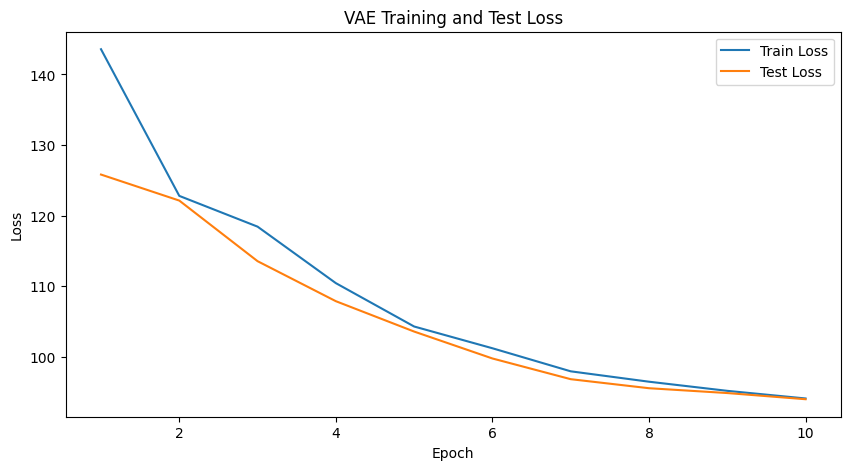

In [38]:
n_epochs = 10
train_losses = []
test_losses = []
for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(epoch)
    test_loss = test_epoch(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
# 可视化训练和测试损失
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Test Loss')
plt.legend()
plt.show()
torch.save(model.state_dict(), 'vae_fc_mse.pth')

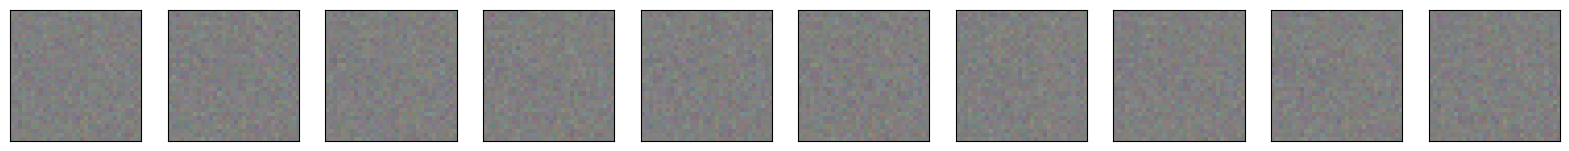

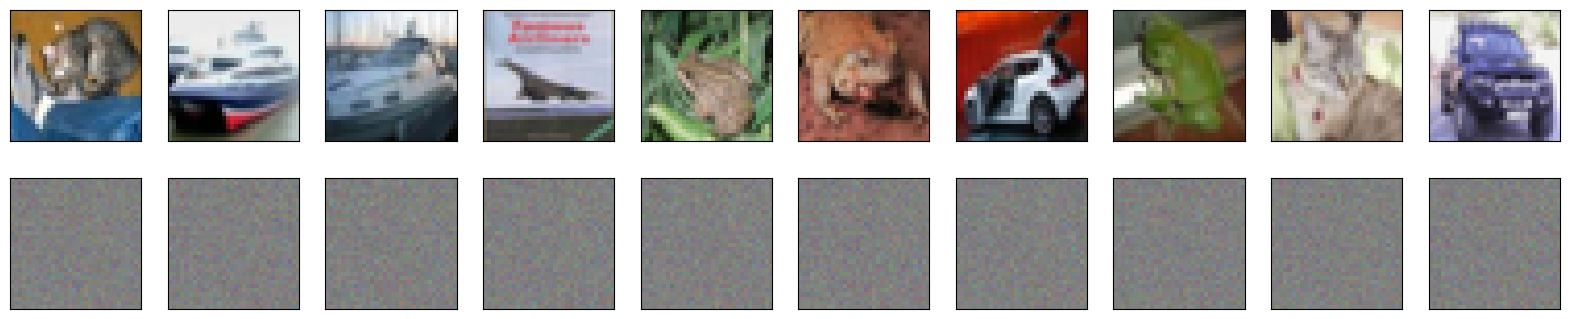

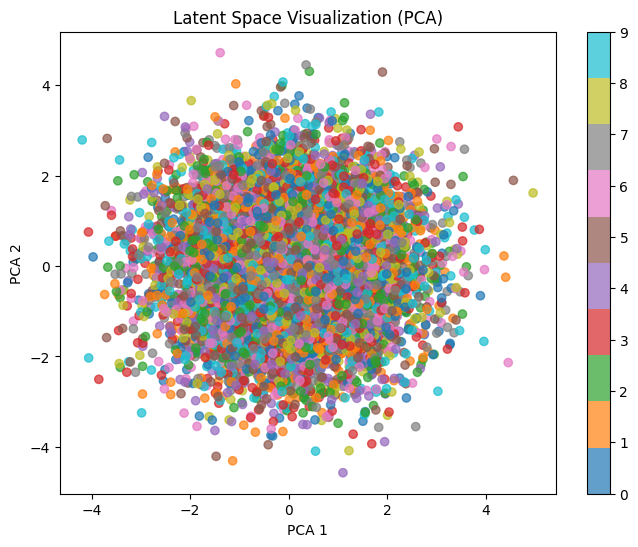

In [42]:
generate_samples(num_samples=10)
visualize_reconstructions()
visualize_latent_space()